In [1]:
!pip install pmdarima
!pip install download
!pip install statsmodels
!pip3 install -U scikit-learn scipy matplotlib
!pip install geopandas

import os
import sys
import urllib.request

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
import geopandas as gpd
import matplotlib.gridspec as gridspec
from pmdarima.arima import auto_arima
import warnings
from zipfile import ZipFile

sys.path.append("./Methods")
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#E5B5B5', '#C7CEEA', '#B5D8EB', '#E2D2B2', '#A0D2DB'])

Agri File already exists, skipping download
Geo File already exists, skipping download
Agri Data loaded successfully into a Pandas DataFrame
Geo Data loaded successfully into a GeoPandas DataFrame


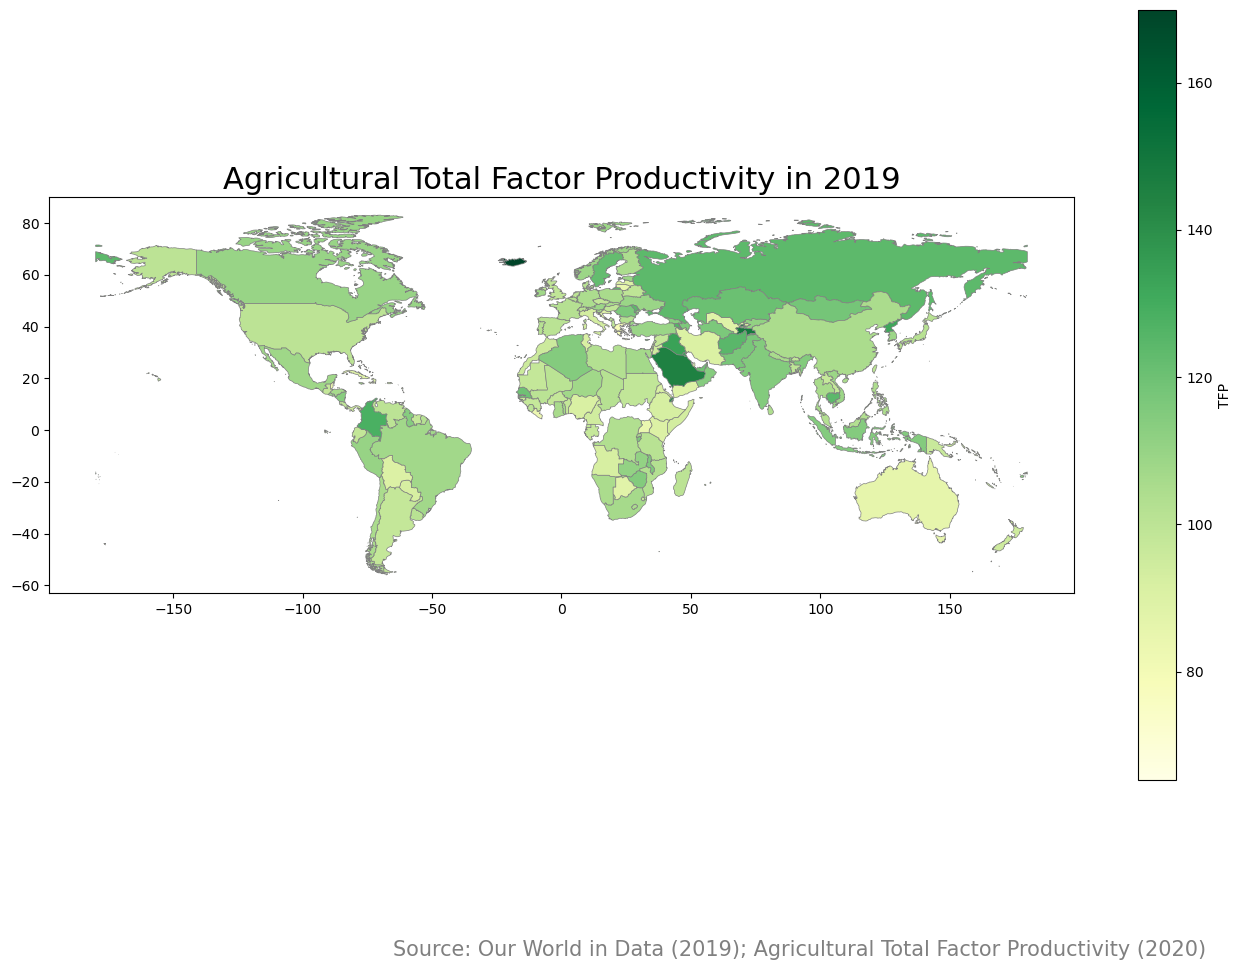

None


In [9]:

class Agros_class:
    """A class for analyzing agricultural data"""
    def __init__(self):
        """
        Initialize the Agros_class object
        Parameters
        ----------
        Nothing
        Returns
        ----------
        Nothing
        """
        self.data = None
        self.file = False
        self.download_file()
        self.read_data()
        

    def download_file(self):
        """
        Download data file into downloads/ directory
        Parameters
        ----------
        Nothing
        Returns
        ----------
        Nothing
        """
        url = "https://raw.githubusercontent.com/owid/owid-datasets/master/datasets/Agricultural%20total%20factor%20productivity%20(USDA)/Agricultural%20total%20factor%20productivity%20(USDA).csv"
        file_path = "downloads/data_file.csv"
        
        geo_url = "https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/50m/cultural/ne_50m_admin_0_countries.zip"
        geo_path = "downloads/ne_50m_admin_0_countries.zip"
        
        if not os.path.exists("downloads"):
            os.makedirs("downloads")
        
        if os.path.exists(file_path):
            print("Agri File already exists, skipping download")
        else:
            print("Downloading Agri file from URL...")
            urllib.request.urlretrieve(url, file_path)
            print("Agri File downloaded successfully")   
        try:
            if not os.path.exists(geo_path):
                req = urllib.request.Request(
                    geo_url,
                    data=None,
                    headers={
                        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36'
                    }
                )
                with urllib.request.urlopen(req) as response, open(geo_path, 'wb') as out_file:
                    out_file.write(response.read())
                with ZipFile(geo_path, 'r') as zipObj:
                    # Extract all the contents of zip file in current directory
                    zipObj.extractall("downloads")
                print("Geo File downloaded successfully")
            else:
                print("Geo File already exists, skipping download")
        except Exception as e:
            print(f"Error downloading Geo file: {e}")
        self.file = True


    def read_data(self):
        """
        Read data file into a Pandas DataFrame
        Parameters
        ----------
        Nothing
        Returns
        ----------
        Nothing
        """
        file_path = "downloads/data_file.csv"
        if os.path.exists(file_path):
            self.data = pd.read_csv(file_path)
            print("Agri Data loaded successfully into a Pandas DataFrame")
        else:
            print("Agri Data file not found")
            
        geo_path = "downloads/ne_50m_admin_0_countries.zip"    
        if os.path.exists(geo_path):
            shpfile = "zip://downloads/ne_50m_admin_0_countries.zip"
            self.geo = gpd.read_file(shpfile)
            print("Geo Data loaded successfully into a GeoPandas DataFrame")
        else:
            print("Geo Data file not found")
        
            
        

    def get_countries(self):
        """
        Get a list of the available countries in the data set
        Parameters
        ----------
        Nothing
        Returns
        ----------
        A list of the available countries in the data set
        """
        if self.data is not None:
            return list(self.data['Entity'].unique())
        else:
            print("Data not loaded yet")
    
    def plot_quantity_correlation(self):
        '''
        Plot a correlation matrix between the "_quantity" columns in the dataset
        Parameters
        ----------
        Nothing
        
        Returns
        ----------
        Nothing
        '''
        if self.data is not None:
            # Select only columns that contain "_quantity"
            quantity_cols = [col for col in self.data.columns if '_quantity' in col]
            # Compute correlation matrix
            corr = self.data[quantity_cols].corr()
            # Plot heatmap of correlation matrix
            sns.heatmap(corr, annot=True, cmap='coolwarm')
            plt.show()
        else:
            print("Data not loaded yet")
    
    def plot_output_area_chart(self, country=None, normalize=False):
        """
        Plot an area chart of the distinct "_output_" columns.
        
        Parameters
        ----------
        country : str or None, default=None
            The name of a country to plot data for. If None or 'World', plot data for the entire world.
        normalize : bool, default=False
            Whether to normalize the data by dividing each row by its sum and multiplying by 100.

        Returns
        ----------
        nothing
        """
        if self.data is None:
            print("Data not loaded yet")
            return

        if country is None or country == 'World':
            data_to_plot = self.data.groupby('Year').sum().loc[:, 'ag_land_quantity':'irrigation_quantity']
        else:
            if country not in self.get_countries():
                raise ValueError(f"{country} does not exist in the dataset")

            data_to_plot = self.data[self.data['Entity'] == country].set_index('Year').loc[:, 'ag_land_quantity':'irrigation_quantity']

        if normalize:
            data_to_plot = data_to_plot.divide(data_to_plot.sum(axis=1), axis=0) * 100
            
        data_to_plot.plot.area()
        plt.xlabel("Year")
        plt.ylabel("Output")
        plt.title(f"{'World' if country is None else country} Output{' (Normalized)' if normalize else ''}")
        plt.show()
    
    def compare_output_total(self, countries):
        """
        Compare the total output of selected countries across years and plot it
        Parameters
        ----------
        countries : str or list
            The name of a country or a list of country names to compare
        ------------
        Returns
        ----------
        nothing
        """
        
        if self.data is None:
            print("Data not loaded yet")
            return
        
        # Convert string to list if only one country is provided
        if isinstance(countries, str):
            countries = [countries]
        
        # Filter data for selected countries
        filtered_data = self.data[self.data['Entity'].isin(countries)]
        
        # Compute total output for each year
        data_to_plot = filtered_data.groupby('Year').sum().loc[:, 'output':'output_quantity']
        data_to_plot['Total'] = data_to_plot.sum(axis=1)
        
        # Plot total output over time for each country
        for country in countries:
            plt.plot(data_to_plot.index, filtered_data[filtered_data['Entity']==country]['output'], label=country)
        
        plt.plot(data_to_plot.index, data_to_plot['Total'], label='Total')
        
        plt.legend()
        plt.xlabel('Year')
        plt.ylabel('Output (US$)')
        plt.show()
    
    def gapminder(self, year):
        '''
        Plot a scatter plot comparing fertilizer_quantity and output_quantity for a given year
        The area of each dot represents a third relevant variable
        Parameters
        ----------
        year: int
        The year to plot the scatter plot for
        ------------
        Returns
        ----------
        nothing
        '''
        # Check if year is an integer
        if not isinstance(year, int):
            raise TypeError("Year must be an integer")
            
        # Filter data for given year
        data_filtered = self.data[self.data['Year'] == year]
            
        # Set area size based on a third relevant variable (here, 'land_area' column)
        area_size = data_filtered['ag_land_quantity']/1000
        
        # Plot scatter plot
        plt.scatter(data_filtered['fertilizer_quantity'], data_filtered['output_quantity'], s=area_size,  alpha=0.4, edgecolors='grey', linewidth=2)

        # Set plot title and axis labels
        plt.title(f"Gapminder Plot for year {year}")
        plt.xlabel("Fertilizer Quantity")
        plt.ylabel("Output Quantity")
        plt.xscale("log")
        plt.yscale("log")
            
        # Show plot
        plt.show()
        
    def choropleth(self, year):
        """
        Creates a choropleth map of the world for a given year.
    
        Parameters
        ----------
        year : int
            The year for which the map should be created.

        Returns
        -------
        A choropleth map of the world for a given year.
        """
    
        if not isinstance(year, int):
            raise ValueError("Year must be an integer.")
        
        #'Democratic Republic of Congo':'Democratic Republic of the Congo','Democratic Republic of Congo':'Dem. Rep. Congo','Congo' :'Republic of the Congo','Dem. Rep. Congo':'Democratic Republic of Congo'
         # Dictionary for merging countries
        self.merge_dict = {
            'United States': 'United States of America',
            'Dominican Republic' : 'Dominica',
            'Democratic Republic of Congo':'Democratic Republic of the Congo',
            'Bahamas' : 'The Bahamas',
            'Tanzania' : 'United Republic of Tanzania',
            'Eswatini' : 'eSwatini',
            'Myanmar' : 'Burma',
            'North Macedonia' : 'Macedonia, Republic of',
            'Central African Republic' : 'Central African Rep.',
            'South Sudan' : 'S. Sudan',
            'Bosnia and Herzegovina':'Bosnia and Herz.',
            'N. Cyprus' : 'Cyprus',
            'Republic of Chad' : 'Chad'
        }

        
        
        # Filter data for given year
        self.data = self.data[self.data['Year'] == year]
        
        #Get the average of the tfp of country in that given year for the case that we have >1 tfp values per country in a year
        #tpf_avg_df = self.data.groupby("Entity")["tfp"].mean().reset_index()
        
        # Rename country names to match the ones in the geographical data
        self.data['Entity'] = self.data['Entity'].replace(self.merge_dict) 
        
        # Read geographical data
        geo_data = self.geo[['ADMIN', 'geometry']]
         
        # Merge dataframes
        merge_data = geo_data.merge(self.data, left_on='ADMIN', right_on='Entity')
        

         # Set up figure and axis
        fig = plt.figure(figsize=(20, 10))
        gs = fig.add_gridspec(nrows=1, ncols=2, width_ratios=[10, 1])
        ax = fig.add_subplot(gs[0])
        ax.set_title(f"Agricultural Total Factor Productivity in {year}", fontsize=22)

        # Plot choropleth
        cmap = 'YlGn'
        merge_data.plot(column='tfp', cmap=cmap, ax=ax, legend=True,
                        legend_kwds={'label': "TFP"},
                        vmin=merge_data['tfp'].min(),
                        vmax=merge_data['tfp'].max(),
                        edgecolor='grey',
                        linewidth=0.5)
        
        # Set aspect ratio to equal
        ax.set_aspect('equal')
        
        # Add source text on the bottom
        source_text = "Source: Our World in Data (2019); Agricultural Total Factor Productivity (2020)"
        fig.text(0.5, -0.05, source_text, fontsize=15, color='grey', ha='center', va='top')
        plt.show()
        return 

        
    def predictor(self,*countries):
        """
        Predict TFP data for up to three countries using an ARIMA model and plot the results
        Parameters
        ----------
        *countries : str
            Names of countries to predict TFP data for. Maximum of three countries allowed.
        ------------
        Returns
        ----------
        nothing
        """
        country_list = self.get_countries()
        valid_countries = [c for c in countries if c in country_list]
        if len(valid_countries) > 3:
            raise ValueError("Max. nr of countries is 3")
        elif len(valid_countries) == 0:
            raise ValueError("No country has been chosen/neither of the countries chosen is valid. The following are:", (country_list))
        
        valid_data = self.data[self.data["Entity"].isin(valid_countries)]
        valid_data = valid_data.set_index("Year")
        valid_data.index = pd.to_datetime(valid_data.index, format="%Y")
        valid_data.index = valid_data.index.year
        valid_data = valid_data[["Entity", "tfp"]]


       # Plot actual and predicted TFP data
        colors = plt.cm.tab10.colors[:len(valid_countries)]
        linestyles = ["-", "-.", ":"]
        plt.rc("axes", prop_cycle=plt.cycler("linestyle", linestyles))
        fig, ax = plt.subplots(figsize=(12, 5))

        for i, country in enumerate(valid_countries):
            country_data = valid_data[valid_data["Entity"] == country]
            ax.plot(country_data["tfp"], color=colors[i], linestyle="-")
            warnings.filterwarnings("ignore")

            # Fit ARIMA model to the data
            model = auto_arima(country_data["tfp"],
                               start_p=1, start_q=1, max_p=5, max_q=5,
                               m=1, start_P=0, seasonal=True, d=None, D=0,
                               trace=True, error_action="ignore", suppress_warnings=True, stepwise=True)

            # Make predictions for future years
            future_years = range(max(valid_data.index)+1, 2051)
            forecast = model.predict(n_periods=len(future_years))

            # Plot predicted TFP values
            ax.plot(future_years, forecast, color=colors[i], linestyle="--", label=country)

        ax.set_xlabel("Year")
        ax.set_ylabel("TFP")
        ax.set_title("Total Factor Productivity")
        ax.set_xticks(range(min(valid_data.index), 2051, 5))
        ax.legend()
        plt.show()
        return 

agros = Agros_class()
print(agros.choropleth(2019))